In [1]:
import glob
import os
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [2]:
def findFiles(path):return glob.glob(path)

PATH = "data_rnn/data/names/"
#print(findFiles(f"{PATH}/*.txt"))
print(findFiles(PATH+"*.txt"))

['data_rnn/data/names\\Arabic.txt', 'data_rnn/data/names\\Chinese.txt', 'data_rnn/data/names\\Czech.txt', 'data_rnn/data/names\\Dutch.txt', 'data_rnn/data/names\\English.txt', 'data_rnn/data/names\\French.txt', 'data_rnn/data/names\\German.txt', 'data_rnn/data/names\\Greek.txt', 'data_rnn/data/names\\Irish.txt', 'data_rnn/data/names\\Italian.txt', 'data_rnn/data/names\\Japanese.txt', 'data_rnn/data/names\\Korean.txt', 'data_rnn/data/names\\Polish.txt', 'data_rnn/data/names\\Portuguese.txt', 'data_rnn/data/names\\Russian.txt', 'data_rnn/data/names\\Scottish.txt', 'data_rnn/data/names\\Spanish.txt', 'data_rnn/data/names\\Vietnamese.txt']


In [3]:
#open(f"{PATH}/Arabic.txt").read().strip().split("\n")[:10]
open(PATH+"Arabic.txt").read().strip().split("\n")[:5]

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']

In [4]:
import string
import unicodedata

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)
print(n_letters)

56


In [5]:
def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD",s) if unicodedata.category(c) != 'Mn')
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_lines = {}
all_categories = []

def readNames(filename):
    lines = open(filename, "r", encoding= 'utf-8').read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]

#for file in findFiles(f"{PATH}/*.TXT"):
for file in findFiles(PATH+"*.txt"):
    language = os.path.splitext(os.path.basename(file))[0]
    category_lines[language] = readNames(file)
    all_categories.append(language)
    
n_categories = len(all_categories)

In [7]:
#find number of languages, and names
for k,v in category_lines.items():
    print("{} has {} names".format(k, len(v)))

Polish has 139 names
Italian has 709 names
Scottish has 100 names
Korean has 94 names
Irish has 232 names
Chinese has 268 names
Portuguese has 74 names
Spanish has 298 names
Greek has 203 names
Vietnamese has 73 names
Japanese has 991 names
German has 724 names
Czech has 519 names
English has 3668 names
Arabic has 2000 names
Russian has 9408 names
French has 277 names
Dutch has 297 names


In [8]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

letterToTensor('J')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [9]:
def lineToTensor(line):
    one_hot_encode = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        one_hot_encode[idx][0][letterToIndex(letter)] = 1
    return one_hot_encode

lineToTensor("xiao").size()

torch.Size([4, 1, 56])

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = F.tanh(self.i2h(combined))
        output = F.tanh(self.i2o(combined))
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor("A")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [12]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.9289, -2.9345, -2.8283, -2.8975, -2.8845, -2.7989, -2.9186, -2.7996,
         -2.9229, -3.0189, -2.9049, -2.8854, -2.8024, -2.8919, -2.8669, -2.9331,
         -2.8644, -2.9752]], grad_fn=<LogSoftmaxBackward>)

In [13]:
def categoryFromOutput(output):
    #top_n is the logprobability, and top_i is the index
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)

('French', 5)

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Polymenakou
category = Portuguese / line = Nunes
category = Korean / line = Jong
category = Scottish / line = Hamilton
category = French / line = Martel
category = Portuguese / line = Basurto
category = Polish / line = Krakowski
category = Irish / line = Colman
category = Chinese / line = Qiao
category = Scottish / line = Mackay


In [15]:
import torch.optim as optim

learning_rate = 5e-3
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward(retain_graph = True)
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [16]:
n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print("{} {}% loss: {:.3f}, {} --> {} {}".format(iter, iter/n_iters*100, loss, line, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.0% loss: 2.982, Rosa --> Japanese ✗ (Italian)
10000 10.0% loss: 3.116, Baumann --> Irish ✗ (German)
15000 15.0% loss: 2.484, Murphy --> English ✗ (Scottish)
20000 20.0% loss: 2.028, Hoefler --> German ✓
25000 25.0% loss: 3.421, Lappo --> Portuguese ✗ (Russian)
30000 30.0% loss: 2.647, Reading --> Dutch ✗ (English)
35000 35.0% loss: 2.133, Caomh --> Arabic ✗ (Irish)
40000 40.0% loss: 2.354, Giolla --> Spanish ✗ (Irish)
45000 45.0% loss: 1.346, Abukhov --> Russian ✓
50000 50.0% loss: 2.869, Felix --> French ✗ (English)
55000 55.00000000000001% loss: 1.612, Banh --> Vietnamese ✓
60000 60.0% loss: 1.708, Leeuwenhoek --> Dutch ✓
65000 65.0% loss: 2.062, Cherry --> Irish ✗ (English)
70000 70.0% loss: 1.378, Iwahashi --> Japanese ✓
75000 75.0% loss: 1.654, Jong --> Vietnamese ✗ (Korean)
80000 80.0% loss: 1.720, Basurto --> Spanish ✓
85000 85.0% loss: 2.090, Pittaluga --> Spanish ✗ (Italian)
90000 90.0% loss: 3.518, Sip --> Korean ✗ (Czech)
95000 95.0% loss: 1.465, Ferguson --> Scottish

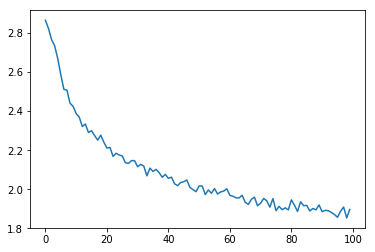

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.plot(all_losses)

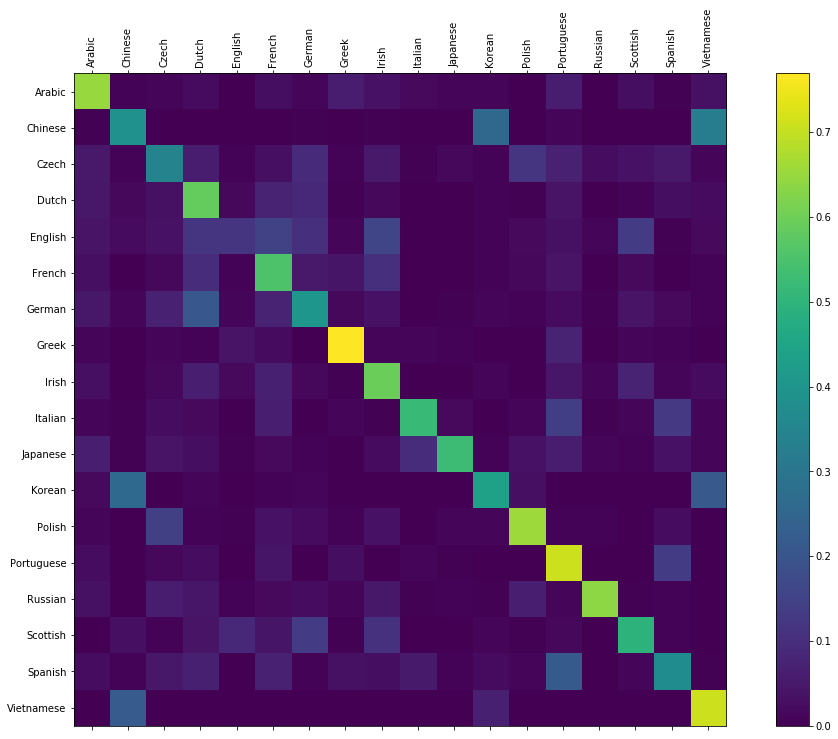

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [19]:
def predict(input_line, n_predictions = 3):
    print("\n > {}".format(input_line))
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("{:.2f} {}".format(value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [20]:
predict("Xiao")
predict("Jackson")
predict("Satoshi")


 > Xiao
-1.56 Vietnamese
-1.57 Chinese
-2.43 Portuguese

 > Jackson
-1.57 English
-1.61 Scottish
-2.63 Czech

 > Satoshi
-1.89 Italian
-2.02 Arabic
-2.03 Portuguese
